In [1]:
import time
import os
import cv2

from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.file.TSV import RegionExporter
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.utilities import *
from lib.analysis.laminar_dist import *

G:/.shortcut-targets-by-id/1agf9hjzkl3u6aOFBWL11nSv61hlCqOtg\2020-12-29\04-01-01_L4_interlaminar ['Old', 'Diagram'] ['04-01-01_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_16.dat', 'LaminarVisual04-01-01.png', 'rois_01_to_15.dat', 'desktop.ini']
slice 4 , rec 1
edge_pts [[44, 0], [26, 0]] axis_pts [[26, 50], [44, 50]]
laminar axis unit vectors: [0.0, -1.0] [0.0, -1.0]
ROI centers: [[34.58, 44.48], [34.5, 40.0], [34.5, 37.0], [34.5, 34.0], [34.5, 31.0], [34.5, 28.0], [34.5, 25.0], [34.5, 22.0], [34.5, 19.0], [34.5, 16.0], [34.5, 13.0], [34.5, 10.0], [34.5, 7.0], [34.5, 4.0], [34.5, 1.0]]
Created file: G:/.shortcut-targets-by-id/1agf9hjzkl3u6aOFBWL11nSv61hlCqOtg\2020-12-29\04-01-01_L4_interlaminar/rois_01_to_15.dat
Stim point: [39, 50]
laminar_distances: [5.52, 10.0, 13.0, 16.0, 19.0, 22.0, 25.0, 28.0, 31.0, 34.0, 37.0, 40.0, 43.0, 46.0, 49.0]
laminar_distances: [5.52, 10.0, 13.0, 16.0, 19.0, 22.0, 25.0, 28.0, 31.0, 34.0, 37.0, 40.0, 43.0, 46.0, 49.0]


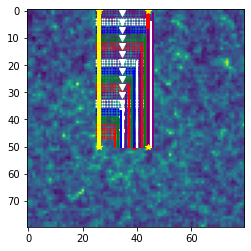

G:/.shortcut-targets-by-id/1agf9hjzkl3u6aOFBWL11nSv61hlCqOtg\2020-12-29\06-01-01_L4_interlaminar ['Diagram'] ['06-01-01_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_17.dat', 'LaminarVisual06-01-01.png', 'rois_01_to_16.dat', 'desktop.ini']
slice 6 , rec 1
edge_pts [[33, 0], [22, 0]] axis_pts [[22, 53], [34, 53]]
laminar axis unit vectors: [-0.018864566947613626, -0.9998220482235222] [0.0, -1.0]
ROI centers: [[27.08, 47.47], [27.0, 43.0], [27.0, 40.0], [27.0, 37.0], [27.0, 34.0], [27.0, 31.0], [27.0, 28.0], [27.0, 25.0], [26.5, 22.0], [26.5, 19.0], [26.5, 16.0], [26.5, 13.0], [26.5, 10.0], [26.5, 7.0], [26.5, 4.0], [26.5, 1.0]]
Created file: G:/.shortcut-targets-by-id/1agf9hjzkl3u6aOFBWL11nSv61hlCqOtg\2020-12-29\06-01-01_L4_interlaminar/rois_01_to_16.dat
Stim point: [26, 53]
laminar_distances: [5.51, 9.98, 12.98, 15.98, 18.98, 21.98, 24.98, 27.98, 30.99, 33.98, 36.98, 39.98, 42.98, 45.98, 48.98, 51.98]
laminar_distances: [5.53, 10.0, 13.0, 16.0, 19.0, 22.0, 25.0, 28.0, 31

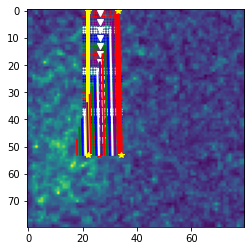

G:/.shortcut-targets-by-id/1agf9hjzkl3u6aOFBWL11nSv61hlCqOtg\2020-12-29\07-01-03_L4_intralaminar ['Diagram'] ['07-01-03_snr.txt', 'electrode.dat', 'corners_layer.dat', 'rois_01_to_16.dat', 'LaminarVisual07-01-03.png', 'rois_01_to_15.dat', 'desktop.ini']
slice 7 , rec 3
edge_pts [[78, 29], [78, 0]] axis_pts [[32, 46], [47, 63]]
laminar axis unit vectors: [0.6737538576856826, -0.7389558439133294] [0.7071067811865476, -0.7071067811865476]
ROI centers: [[41.34, 49.34], [44.15, 46.54], [46.21, 44.17], [48.24, 41.95], [50.52, 40.12], [52.55, 37.88], [54.26, 35.19], [56.7, 33.47], [58.73, 31.21], [60.51, 28.75], [62.52, 26.58], [64.41, 24.25], [66.63, 22.21], [68.72, 20.1], [70.44, 17.61]]
Created file: G:/.shortcut-targets-by-id/1agf9hjzkl3u6aOFBWL11nSv61hlCqOtg\2020-12-29\07-01-03_L4_intralaminar/rois_01_to_15.dat
Stim point: [39, 54]
laminar_distances: [5.02, 8.98, 12.12, 15.13, 18.02, 21.04, 24.18, 27.1, 30.13, 33.15, 36.11, 39.1, 42.11, 45.08, 48.08]
laminar_distances: [4.95, 8.92, 12.05

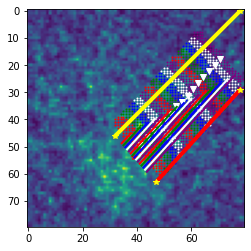

G:/.shortcut-targets-by-id/1agf9hjzkl3u6aOFBWL11nSv61hlCqOtg\2020-12-29\09-01-02_L4_interlaminar ['Diagram'] ['09-01-02_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_07.dat', 'LaminarVisual09-01-02.png', 'rois_01_to_06.dat', 'desktop.ini']
slice 9 , rec 2
edge_pts [[28, 79], [79, 66]] axis_pts [[34, 58], [79, 43]]
laminar axis unit vectors: [-0.27472112789737807, 0.9615239476408232] [0.0, 1.0]
ROI centers: [[55.13, 52.72], [53.47, 57.58], [52.84, 60.49], [52.01, 63.39], [50.65, 66.46], [51.0, 68.95]]
Created file: G:/.shortcut-targets-by-id/1agf9hjzkl3u6aOFBWL11nSv61hlCqOtg\2020-12-29\09-01-02_L4_interlaminar/rois_01_to_06.dat
Stim point: [32, 64]
laminar_distances: [17.2, 12.07, 9.1, 6.08, 2.76, 0.46]
laminar_distances: [11.28, 6.42, 3.51, 0.61, 2.46, 4.95]


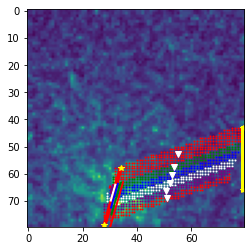

G:/.shortcut-targets-by-id/1ajxLM6KdaTZ0ZxmNJP8D_fyPPmPmNmTm\2021-01-18\05-01-03_L23_interlaminar ['Old', 'Diagram'] ['05-01-03_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_16.dat', 'LaminarVisual05-01-03.png', 'rois_01_to_15.dat', 'desktop.ini']
slice 5 , rec 3
edge_pts [[18, 79], [48, 79]] axis_pts [[23, 27], [55, 31]]
laminar axis unit vectors: [-0.09571240664425779, 0.9954090291002811] [-0.14430689307172856, 0.9895329810632816]
ROI centers: [[38.53, 31.45], [37.37, 35.75], [37.39, 38.85], [37.78, 41.93], [36.57, 44.79], [36.67, 47.86], [36.5, 50.85], [36.39, 53.85], [35.6, 56.69], [35.43, 59.8], [35.5, 62.85], [34.69, 65.72], [34.67, 68.75], [34.5, 71.74], [34.56, 74.8]]
Created file: G:/.shortcut-targets-by-id/1ajxLM6KdaTZ0ZxmNJP8D_fyPPmPmNmTm\2021-01-18\05-01-03_L23_interlaminar/rois_01_to_15.dat
Stim point: [41, 29]
laminar_distances: [2.67, 7.06, 10.15, 13.18, 16.14, 19.19, 22.18, 25.18, 28.08, 31.19, 34.22, 37.15, 40.17, 43.16, 46.21]
laminar_distances: [2.78, 

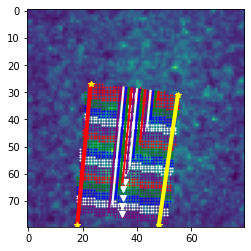

G:/.shortcut-targets-by-id/1ajxLM6KdaTZ0ZxmNJP8D_fyPPmPmNmTm\2021-01-18\04-01-02_L23_interlaminar ['Old', 'Diagram'] ['04-01-02_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_06.dat', 'LaminarVisual04-01-02.png', 'rois_01_to_05.dat', 'desktop.ini']
slice 4 , rec 2
edge_pts [[2, 40], [69, 79]] axis_pts [[8, 22], [78, 62]]
laminar axis unit vectors: [-0.31622776601683794, 0.9486832980505138] [-0.46788772041903276, 0.8837879163470619]
ROI centers: [[41.51, 44.17], [40.23, 48.42], [39.83, 51.59], [38.47, 54.16], [37.31, 56.9]]
Created file: G:/.shortcut-targets-by-id/1ajxLM6KdaTZ0ZxmNJP8D_fyPPmPmNmTm\2021-01-18\04-01-02_L23_interlaminar/rois_01_to_05.dat
Stim point: [6, 28]
laminar_distances: [4.11, 8.55, 11.68, 14.55, 17.52]
laminar_distances: [2.32, 2.03, 5.02, 7.93, 10.89]


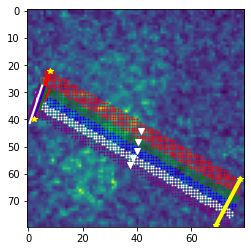

G:/.shortcut-targets-by-id/1ajxLM6KdaTZ0ZxmNJP8D_fyPPmPmNmTm\2021-01-18\07-01-02_L23_interlaminar ['Old', 'Diagram'] ['07-01-02_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_20.dat', 'LaminarVisual07-01-02.png', 'rois_01_to_19.dat', 'desktop.ini']
slice 7 , rec 2
edge_pts [[78, 65], [78, 47]] axis_pts [[18, 41], [16, 62]]
laminar axis unit vectors: [0.9988313960820002, 0.04833055142332259] [0.9950371902099892, 0.09950371902099892]
ROI centers: [[20.54, 49.95], [24.16, 50.0], [27.18, 50.13], [30.15, 50.5], [33.13, 50.55], [36.1, 50.78], [39.12, 51.0], [42.12, 51.0], [45.12, 51.0], [48.13, 51.26], [51.12, 51.5], [54.12, 51.5], [57.1, 51.78], [60.12, 52.0], [63.12, 52.0], [66.12, 52.0], [69.12, 52.42], [72.12, 52.5], [75.1, 52.42]]
Created file: G:/.shortcut-targets-by-id/1ajxLM6KdaTZ0ZxmNJP8D_fyPPmPmNmTm\2021-01-18\07-01-02_L23_interlaminar/rois_01_to_19.dat
Stim point: [17, 50]
laminar_distances: [3.53, 7.15, 10.18, 13.16, 16.14, 19.12, 22.14, 25.14, 28.14, 31.15, 34.15, 

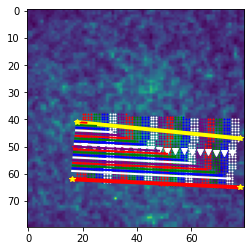

G:/.shortcut-targets-by-id/1aoO9ONkw-79Ry8wCPc1izW73Eoc6YO5-\2021-01-19\05-01-01_L23_interlaminar ['Old', 'Diagram'] ['05-01-01_snr.txt', 'corners_barrel.dat', 'electrode.dat', 'rois_01_to_12.dat', 'LaminarVisual05-01-01.png', 'rois_01_to_11.dat', 'desktop.ini']
slice 5 , rec 1
edge_pts [[37, 79], [78, 59]] axis_pts [[22, 31], [5, 64]]
laminar axis unit vectors: [0.9054589359588684, 0.4244338762307196] [0.8944271909999159, 0.4472135954999579]
ROI centers: [[16.85, 47.3], [20.35, 49.44], [23.21, 50.42], [26.07, 51.42], [28.72, 52.8], [31.09, 54.76], [34.35, 54.93], [36.81, 56.72], [39.48, 58.1], [42.23, 59.27], [44.98, 60.53]]
Created file: G:/.shortcut-targets-by-id/1aoO9ONkw-79Ry8wCPc1izW73Eoc6YO5-\2021-01-19\05-01-01_L23_interlaminar/rois_01_to_11.dat
Stim point: [14, 47]
laminar_distances: [2.71, 6.78, 9.79, 12.81, 15.79, 18.77, 21.8, 24.78, 27.78, 30.77, 33.79]
laminar_distances: [2.68, 6.77, 9.77, 12.78, 15.76, 18.76, 21.75, 24.75, 27.76, 30.74, 33.76]


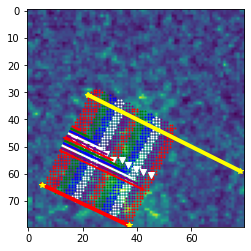

G:/.shortcut-targets-by-id/1aiA17l3WSNA3lJrBRw6fZUtC8pb2V6sS\2021-01-11\07-01-02_L23_interlaminar ['Old', 'Diagram'] ['07-01-02_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_17.dat', 'LaminarVisual07-01-02.png', 'rois_01_to_16.dat', 'desktop.ini']
slice 7 , rec 2
edge_pts [[24, 79], [47, 79]] axis_pts [[24, 26], [47, 27]]
laminar axis unit vectors: [0.0, 1.0] [0.0, 1.0]
ROI centers: [[35.08, 28.97], [35.0, 33.44], [35.0, 36.44], [35.0, 39.44], [35.0, 42.44], [35.0, 45.44], [35.0, 48.44], [35.0, 51.44], [35.0, 54.44], [35.0, 57.44], [35.0, 60.44], [35.0, 63.44], [35.0, 66.44], [35.0, 69.44], [35.0, 72.44], [35.0, 75.44]]
Created file: G:/.shortcut-targets-by-id/1aiA17l3WSNA3lJrBRw6fZUtC8pb2V6sS\2021-01-11\07-01-02_L23_interlaminar/rois_01_to_16.dat
Stim point: [41, 27]
laminar_distances: [1.97, 6.44, 9.44, 12.44, 15.44, 18.44, 21.44, 24.44, 27.44, 30.44, 33.44, 36.44, 39.44, 42.44, 45.44, 48.44]
laminar_distances: [1.97, 6.44, 9.44, 12.44, 15.44, 18.44, 21.44, 24.44, 27.4

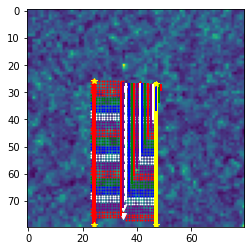

G:/.shortcut-targets-by-id/1aiA17l3WSNA3lJrBRw6fZUtC8pb2V6sS\2021-01-11\09-01-01_L23_interlaminar ['Old', 'Diagram'] ['09-01-01_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_15.dat', 'LaminarVisual09-01-01.png', 'rois_01_to_14.dat', 'desktop.ini']
slice 9 , rec 1
edge_pts [[48, 79], [29, 79]] axis_pts [[27, 34], [44, 34]]
laminar axis unit vectors: [0.08853979028379436, 0.9960726406926864] [0.04440061362072038, 0.9990138064662086]
ROI centers: [[35.08, 36.48], [35.95, 40.81], [35.5, 43.95], [36.16, 46.98], [36.34, 49.93], [36.81, 52.84], [36.81, 55.93], [37.0, 58.95], [37.34, 61.93], [37.81, 64.84], [37.98, 67.95], [38.0, 70.95], [38.66, 73.89], [38.66, 76.89]]
Created file: G:/.shortcut-targets-by-id/1aiA17l3WSNA3lJrBRw6fZUtC8pb2V6sS\2021-01-11\09-01-01_L23_interlaminar/rois_01_to_14.dat
Stim point: [38, 34]
laminar_distances: [2.21, 6.6, 9.69, 12.77, 15.72, 18.66, 21.74, 24.76, 27.76, 30.7, 33.81, 36.8, 39.79, 42.77]
laminar_distances: [2.35, 6.71, 9.83, 12.89, 15.84, 

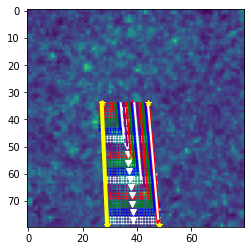

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\08-01-04_aka_part2_05-01-04_L4_interlaminar ['Old', 'Diagram'] ['08-01-04_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'LaminarVisual08-01-04.png', 'rois_01_to_16.dat', 'desktop.ini']
slice 8 , rec 4
edge_pts [[79, 55], [79, 0]] axis_pts [[28, 53], [28, 0]]
laminar axis unit vectors: [0.9992319507315425, 0.039185566695354605] [1.0, 0.0]
ROI centers: [[31.51, 26.38], [35.0, 26.5], [38.0, 26.5], [41.01, 26.84], [44.0, 27.0], [47.0, 27.0], [50.0, 27.0], [53.0, 27.0], [56.0, 27.0], [59.0, 27.0], [62.0, 27.0], [65.0, 27.0], [68.0, 27.5], [71.0, 27.5], [74.0, 27.5], [77.0, 27.5]]
Created file: G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\08-01-04_aka_part2_05-01-04_L4_interlaminar/rois_01_to_16.dat
Stim point: [19, 54]
laminar_distances: [11.41, 14.91, 17.91, 20.92, 23.92, 26.92, 29.92, 32.92, 35.91, 38.91, 41.91, 44.91, 47.92, 50.92, 53.92, 56.92]
laminar_distances: [12.51, 16.0, 19.0, 22.

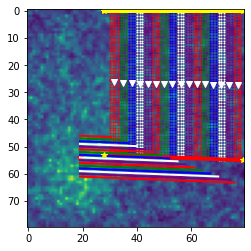

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\10-01-01_aka_part2_07-01-01_L4_interlaminar ['Old', 'Diagram'] ['10-01-01_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'LaminarVisual10-01-01.png', 'rois_01_to_13.dat', 'desktop.ini']
slice 10 , rec 1
edge_pts [[79, 33], [79, 66]] axis_pts [[37, 63], [34, 33]]
laminar axis unit vectors: [1.0, 0.0] [0.997458699830735, 0.07124704998790965]
ROI centers: [[39.04, 46.35], [42.68, 46.5], [45.68, 46.5], [48.68, 46.5], [51.68, 46.5], [54.68, 46.5], [57.68, 46.5], [60.68, 46.5], [63.68, 46.5], [66.68, 46.5], [69.68, 46.5], [72.68, 46.5], [75.68, 46.5]]
Created file: G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\10-01-01_aka_part2_07-01-01_L4_interlaminar/rois_01_to_13.dat
Stim point: [36, 57]
laminar_distances: [3.04, 6.68, 9.68, 12.68, 15.68, 18.68, 21.68, 24.68, 27.68, 30.68, 33.68, 36.68, 39.68]
laminar_distances: [2.28, 5.91, 8.9, 11.9, 14.89, 17.88, 20.87, 23.87, 26.86, 29.85, 32.84, 35.84

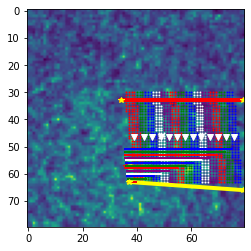

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\06-01-01_aka_part2_03-01-01_L4_interlaminar ['Old', 'Diagram'] ['06-01-01_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'LaminarVisual06-01-01.png', 'rois_01_to_14.dat', 'desktop.ini']
slice 6 , rec 1
edge_pts [[79, 40], [79, 26]] axis_pts [[37, 45], [32, 56]]
laminar axis unit vectors: [0.946649906050144, -0.3222637978043043] [0.9111079228383558, -0.4121678698554467]
ROI centers: [[37.83, 47.57], [41.95, 46.05], [44.87, 44.97], [47.61, 44.03], [50.44, 43.19], [53.31, 42.21], [56.12, 41.33], [59.02, 40.37], [61.82, 39.59], [64.61, 38.53], [67.56, 37.24], [70.55, 36.05], [73.22, 35.58], [76.15, 34.4]]
Created file: G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\06-01-01_aka_part2_03-01-01_L4_interlaminar/rois_01_to_14.dat
Stim point: [33, 54]
laminar_distances: [6.65, 11.04, 14.15, 17.04, 20.0, 23.03, 25.98, 29.03, 31.93, 34.91, 38.12, 41.33, 44.02, 47.16]
laminar_distances: [7.05, 11.43,

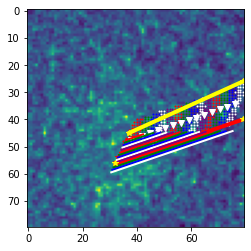

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\03-01-08_aka_02-01-08_L23_intralaminar ['Old', 'Diagram'] ['03-01-08_snr.txt', 'electrode.dat', 'corners_layer.dat', 'LaminarVisual03-01-08.png', 'rois_01_to_14.dat', 'rois_01_to_13.dat', 'desktop.ini']
slice 3 , rec 8
edge_pts [[55, 0], [73, 0]] axis_pts [[40, 47], [29, 36]]
laminar axis unit vectors: [0.5854905538443584, -0.8106792283998809] [0.5746304214759497, -0.8184130245263527]
ROI centers: [[36.79, 36.8], [39.32, 33.81], [40.89, 30.98], [42.76, 28.56], [44.47, 26.31], [46.17, 23.91], [47.81, 21.48], [49.98, 19.19], [51.42, 16.27], [53.38, 14.18], [54.98, 11.81], [56.63, 9.29], [58.65, 7.06]]
Created file: G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\03-01-08_aka_02-01-08_L23_intralaminar/rois_01_to_13.dat
Stim point: [35, 42]
laminar_distances: [5.26, 9.17, 12.38, 15.44, 18.27, 21.21, 24.13, 27.26, 30.47, 33.31, 36.18, 39.18, 42.17]
laminar_distances: [5.28, 9.19, 12.4, 15.46, 18.

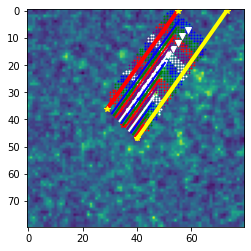

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\04-01-01_aka_03-01-01_L4_interlaminar ['Old', 'Diagram'] ['04-01-01_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'LaminarVisual04-01-01.png', 'rois_01_to_08.dat', 'desktop.ini']
slice 4 , rec 1
edge_pts [[29, 79], [0, 79]] axis_pts [[26, 46], [44, 58]]
laminar axis unit vectors: [-0.5812381937190965, 0.813733471206735] [-0.6188722266035128, 0.7854916722275356]
ROI centers: [[31.79, 53.24], [29.78, 57.0], [27.65, 59.12], [25.91, 61.51], [24.29, 64.13], [22.75, 66.67], [20.59, 68.78], [19.04, 71.39]]
Created file: G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\04-01-01_aka_03-01-01_L4_interlaminar/rois_01_to_08.dat
Stim point: [29, 48]
laminar_distances: [2.64, 6.87, 9.83, 12.79, 15.86, 18.82, 21.79, 24.83]
laminar_distances: [2.39, 6.59, 9.57, 12.53, 15.58, 18.53, 21.52, 24.54]


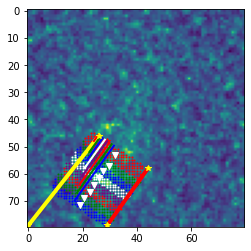

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\11-01-06_aka_part2_08-01-06_L4_interlaminar ['Old', 'Diagram'] ['11-01-06_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'LaminarVisual11-01-06.png', 'rois_01_to_15.dat', 'desktop.ini']
slice 11 , rec 6
edge_pts [[31, 0], [16, 0]] axis_pts [[19, 50], [34, 50]]
laminar axis unit vectors: [-0.05989229072794672, -0.9982048454657786] [-0.05989229072794672, -0.9982048454657786]
ROI centers: [[25.58, 44.48], [25.5, 40.0], [25.0, 37.0], [25.0, 34.0], [24.5, 31.0], [24.5, 28.0], [24.5, 25.0], [24.34, 22.02], [24.0, 19.0], [24.0, 16.0], [23.35, 13.04], [23.5, 10.0], [23.5, 7.0], [23.0, 4.0], [23.0, 1.0]]
Created file: G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\11-01-06_aka_part2_08-01-06_L4_interlaminar/rois_01_to_15.dat
Stim point: [23, 50]
laminar_distances: [5.36, 9.83, 12.86, 15.85, 18.88, 21.87, 24.87, 27.85, 30.88, 33.88, 36.88, 39.9, 42.89, 45.92, 48.91]
laminar_distances: [5.36, 9.83, 

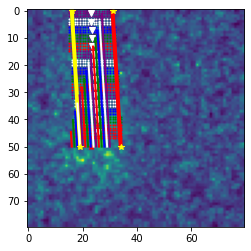

In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/Kate's/ROI_dist/"
data_dir = "G:/.shortcut-targets-by-id/"
corners_file_prefix_layer = 'corners_layer'
corners_file_prefix_barrel = 'corners_barrel'
electrode_file_prefix = 'electrode'
rois_file_prefix = 'rois' # e.g. 'rois_01_to_09.dat'
snr_file_prefix = 'SNR'

image_data = {}
n_plots = 50  # how many to show

for subdir, dirs, files in os.walk(data_dir):
    depth = subdir.count('/') + subdir.count('\\')
    if depth > 4:  # don't care about any deeper dir
        continue
    if 'notUsable' in subdir:
        continue
    if depth == 4:
        print(subdir, dirs, files)
    subdir += '/'
    for filename in files:
        if filename.split(".")[0].endswith("_snr"):
            name_parse = filename[:8]  # of the format 07_01_01
            try:
                slic, loc, rec = [int(x) for x in name_parse.split('-')]
            except ValueError:
                continue
            if slic not in image_data:
                image_data[slic] = {}
            if loc not in image_data[slic]:
                image_data[slic][loc] = {}
            snr = np.loadtxt(subdir + filename,
                             delimiter='\t',
                             usecols=(1,))
            width = int(np.sqrt(snr.shape[0]))
            snr = snr.reshape((width, width))

            print("slice", slic, ", rec", rec)

            # open corners, interlaminar, 2 points p1, p2 to define the edge along which to measure
            
            for la_file in [subdir + corners_file_prefix_layer + '.dat', 
                            subdir + corners_file_prefix_barrel + '.dat']:
                lines = None
                if os.path.exists(la_file):
                    with open(la_file, 'r') as f:
                        lines = f.readlines() 
                    corners = [int(x) for x in lines[4:]] # the last 4 lines are diode numbers of corners
                    layer_axes = LayerAxes(corners)
                    laminar_axis, laminar_axis_2 = layer_axes.get_layer_axes()
                    print("laminar axis unit vectors:", laminar_axis.get_unit_vector(), 
                          laminar_axis_2.get_unit_vector())

                    # make our own ROIs from the list of edges and write them to a .dat file
                    roi_cr = ROICreator(layer_axes)
                    rois = roi_cr.get_rois()  # list of LaminarROI objects
                    roi_centers = [r.get_center() for r in rois]
                    roi_centers = [[round(r[0], 2), round(r[1], 2)] for r in roi_centers]
                    print("ROI centers:", roi_centers)
                    
                    # write these ROIs to file
                    roi_cr.write_roi_file(subdir, rois_file_prefix)

                    # open stim point roi as a single integer (its diode number) in variable stim_pt
                    sp_file = subdir + electrode_file_prefix + '.dat'
                    with open(sp_file, 'r') as f:
                        lines = f.readlines()
                    stim_pt = int(lines[-1]) # last line is always electrode location
                    aux_obj = LaminarROI([stim_pt]).get_points()
                    stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
                    print("Stim point:", stim_pt)

                    # run laminar dist computation
                    laminar_distances = LaminarDistance(laminar_axis, rois, stim_pt).compute_laminar_distances()
                    laminar_distances = [round(ld, 2) for ld in laminar_distances]
                    print('laminar_distances:', laminar_distances)  # a list of integers with same indexing as rois

                    # run laminar dist again with the other axis
                    laminar_distances_2 = LaminarDistance(laminar_axis_2, rois, stim_pt).compute_laminar_distances()
                    laminar_distances_2 = [round(ld, 2) for ld in laminar_distances_2]
                    print('laminar_distances:', laminar_distances_2)  # a list of integers with same indexing as rois

                    image_data[slic][loc][rec] = {
                        'snr': snr,
                        'filename': filename,
                        'laminar_distances': laminar_distances}

                    # Now that the data is stored, show intermediate computations in plot
                    if n_plots > 0:
                        lines = [laminar_axis.get_line_repr(),
                                 laminar_axis_2.get_line_repr()]
                        line_colors = ['red', 'yellow']
                        linewidths = [4,4]
                        other_colors = ['red', 'green', 'blue', 'white', 'purple']
                        roi_colors = []

                        # laminar aux lines
                        uv = laminar_axis.get_unit_vector()
                        for i in range(len(laminar_distances)):
                            ld = laminar_distances[i]
                            jiggle = i - int(len(laminar_distances) / 2)
                            uv_perp = Line(laminar_axis.get_start_point(), 
                                           laminar_axis_2.get_start_point()).get_unit_vector()
                            stim_proxy_pt = [stim_pt[0] - jiggle * uv_perp[0], 
                                             stim_pt[1] - jiggle * uv_perp[1]]
                            measure_vector = [uv[0] * ld + stim_proxy_pt[0], uv[1] * ld + stim_proxy_pt[1]]
                            lines.append([measure_vector, stim_proxy_pt])
                            this_color = other_colors[i % len(other_colors)]
                            line_colors.append(this_color)
                            roi_colors.append(this_color)
                            linewidths.append(2)

                        LaminarVisualization(snr, 
                                             stim_pt, 
                                             roi_centers, 
                                             layer_axes.get_corners(),
                                             lines,
                                             line_colors,
                                             linewidths,
                                             rois,
                                             roi_colors,
                                             save_dir=subdir+"LaminarVisual"+name_parse+'.png')
                        n_plots -= 1
